In [17]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


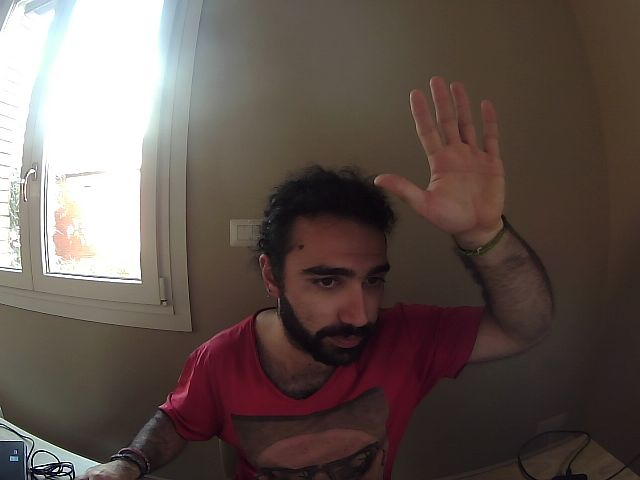

In [18]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
!pip install ultralytics

In [69]:
# https://alimustoofaa.medium.com/yolov8-pose-estimation-and-pose-keypoint-classification-using-neural-net-pytorch-98469b924525

In [70]:
from pydantic import BaseModel

class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16



In [71]:
def get_rectangle_area(img):
    img_draw = img.copy()

    # Get image height and width
    height, width = img.shape[:2]

    # Calculate center coordinates for the rectangle
    center_x = int(width / 2)
    center_y = int(height / 2)

    # Define rectangle dimensions (adjust width and height as needed)
    rectangle_width = 200
    rectangle_height = 200

    # Top-left corner coordinates of the rectangle
    top_left_x = center_x - int(rectangle_width / 2)
    top_left_y = center_y - int(rectangle_height / 2)

    # Bottom-right corner coordinates (calculated automatically)
    bottom_right_x = top_left_x + rectangle_width
    bottom_right_y = top_left_y + rectangle_height

    # Define rectangle color (BGR format)
    color = (0, 255, 0)  # Green color

    # Draw the rectangle on the image
    cv2.rectangle(img_draw, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), color, thickness=2)
    return img_draw, [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

def is_point_inside_rectangle(x, y, x1, y1, width, height):
  """
  Checks if a point (x, y) is inside a rectangle defined by top-left corner (x1, y1) and dimensions (width, height).

  Args:
      x: X-coordinate of the point.
      y: Y-coordinate of the point.
      x1: X-coordinate of the top-left corner of the rectangle.
      y1: Y-coordinate of the top-left corner of the rectangle.
      width: Width of the rectangle.
      height: Height of the rectangle.

  Returns:
      True if the point is inside the rectangle, False otherwise.
  """

  # Check if the point is within the horizontal and vertical boundaries of the rectangle.
  return x1 <= x <= x1 + width and y1 <= y <= y1 + height

In [72]:
from ultralytics import YOLO
import cv2

# example
get_keypoint = GetKeypoint()

# Load a pretrained YOLOv8 pose model
model = YOLO('yolov8m-pose.pt')

# Run inference on an image
img = cv2.imread("photo.jpg", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Get a rectangle inside the image
img_draw, [xr1,yr1,xr2,yr2] = get_rectangle_area(img)

results = model('photo.jpg')

keypoint = results[0].keypoints.xyn.cpu().numpy()

# Iterate over the images
for result in results:
    all_keypoints = result.keypoints.xy.cpu().numpy()
    for i in range(0, len(all_keypoints)):
        score = result.boxes[i].conf.cpu().numpy().item()
        id = int( result.boxes[i].cls.cpu().numpy().item() )
        name = result.names[id]

        # Check if there is a person and the eye are inside the area!
        if score >0.8 and name=="person":
            box_xyxy = result.boxes[i].xyxy.cpu().numpy()[0]
            x1, y1, x2, y2 = box_xyxy.astype(int)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
            cv2.putText(img, f"{name}: {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            keypoints = all_keypoints[i]
            nose_x,           nose_y = keypoints[get_keypoint.NOSE]
            left_eye_x,       left_eye_y = keypoints[get_keypoint.LEFT_EYE]
            right_eye_x,      right_eye_y = keypoints[get_keypoint.RIGHT_EYE]
            left_ear_x,       left_ear_y = keypoints[get_keypoint.LEFT_EAR]
            right_ear_x,      right_ear_y = keypoints[get_keypoint.RIGHT_EAR]
            left_shoulder_x,  left_shoulder_y = keypoints[get_keypoint.LEFT_SHOULDER]
            right_shoulder_x, right_shoulder_y = keypoints[get_keypoint.RIGHT_SHOULDER]
            left_elbow_x,     left_elbow_y = keypoints[get_keypoint.LEFT_ELBOW]
            right_elbow_x,    right_elbow_y = keypoints[get_keypoint.RIGHT_ELBOW]
            left_wrist_x,     left_wrist_y = keypoints[get_keypoint.LEFT_WRIST]
            right_wrist_x,    right_wrist_y = keypoints[get_keypoint.RIGHT_WRIST]
            left_hip_x,       left_hip_y = keypoints[get_keypoint.LEFT_HIP]
            right_hip_x,      right_hip_y = keypoints[get_keypoint.RIGHT_HIP]
            left_knee_x,      left_knee_y = keypoints[get_keypoint.LEFT_KNEE]
            right_knee_x,     right_knee_y = keypoints[get_keypoint.RIGHT_KNEE]
            left_ankle_x,     left_ankle_y = keypoints[get_keypoint.LEFT_ANKLE]
            right_ankle_x,    right_ankle_y = keypoints[get_keypoint.RIGHT_ANKLE]

            cv2.circle(img, (int(nose_x), int(nose_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_eye_x), int(left_eye_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_eye_x), int(right_eye_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_ear_x), int(left_ear_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_ear_x), int(right_ear_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_shoulder_x), int(left_shoulder_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_shoulder_x), int(right_shoulder_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_elbow_x), int(left_elbow_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_elbow_x), int(right_elbow_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_wrist_x), int(left_wrist_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_wrist_x), int(right_wrist_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_hip_x), int(left_hip_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_hip_x), int(right_hip_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_knee_x), int(left_knee_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_knee_x), int(right_knee_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(left_ankle_x), int(left_ankle_y)), 5, (0, 0, 255), -1)
            cv2.circle(img, (int(right_ankle_x), int(right_ankle_y)), 5, (0, 0, 255), -1)

            left_inside = is_point_inside_rectangle(left_eye_x, left_eye_y, xr1,yr1, xr2-xr1,yr2-yr1)
            right_inside = is_point_inside_rectangle(right_eye_x, right_eye_y, xr1,yr1, xr2-xr1,yr2-yr1)

            if left_inside and right_inside:
                print("Concentrated")
            else:
                print("Focus Please!")




image 1/1 /content/photo.jpg: 480x640 1 person, 1581.5ms
Speed: 2.4ms preprocess, 1581.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Concentrated


array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [ 82,  66,  50],
        [ 82,  66,  50],
        [ 83,  67,  51]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [ 81,  65,  49],
        [ 82,  66,  50],
        [ 82,  66,  50]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [ 81,  65,  49],
        [ 82,  66,  50],
        [ 82,  66,  50]],

       ...,

       [[ 30,  37,  47],
        [ 30,  37,  47],
        [ 31,  38,  48],
        ...,
        [ 67,  55,  43],
        [ 64,  51,  42],
        [ 62,  50,  38]],

       [[ 29,  36,  46],
        [ 29,  36,  46],
        [ 30,  37,  47],
        ...,
        [ 65,  51,  38],
        [ 67,  53,  42],
        [ 69,  55,  42]],

       [[ 28,  35,  45],
        [ 28,  35,  45],
        [ 29,  36,  46],
        ...,
        [ 68,  54,  41],
        [ 66,  52,  39],
        [ 64,  50,  37]]], dtype=uint8)
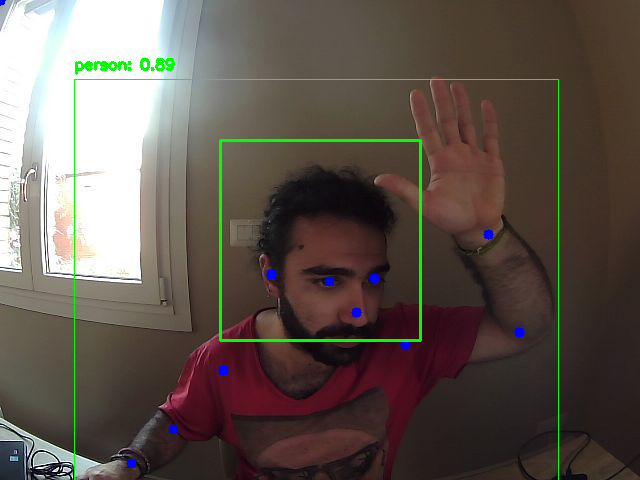

In [73]:
img_draw, [x1,y1,x2,y2] = get_rectangle_area(img)
display(img_draw)

## Sample code

```python
from ultralytics import YOLO
import cv2
from PIL import Image

l = ["NOSE",           
     "LEFT_EYE",       
     "RIGHT_EYE",      
     "LEFT_EAR",       
     "RIGHT_EAR",      
     "LEFT_SHOULDER",  
     "RIGHT_SHOULDER",
     "LEFT_ELBOW",     
     "RIGHT_ELBOW",    
     "LEFT_WRIST",     
     "RIGHT_WRIST",    
     "LEFT_HIP",       
     "RIGHT_HIP",      
     "LEFT_KNEE",      
     "RIGHT_KNEE",     
     "LEFT_ANKLE",     
     "RIGHT_ANKLE"]

model = YOLO('yolov8n-pose.pt')

# .pt --> onnx --> tensort
webcam = cv2.VideoCapture(0)
while True:
    check, im = webcam.read()
    if check:
        res = model(im, imgsz=320)

        im_draw = im.copy()
        cx,cy = im_draw.shape[1]//2 ,im_draw.shape[0]//2
        size = 100
        x1,y1 = cx-size,cy-size
        x2,y2 = cx+size,cy+size
        cv2.circle(im_draw, (x1,y1), 5, (255,255,0),-1)
        cv2.circle(im_draw, (x2,y2), 5, (0,0,255),-1)
        cv2.rectangle(im_draw, (x1,y1),(x2,y2), (0,255,0),1)

        points = res[0].keypoints.xy.cpu().numpy().reshape(-1,2)
        i = 0
        for point in list(points.astype(int)):
            x,y = point

            if (l[i]=="LEFT_EYE" or l[i]=="RIGHT_EYE"):
                cv2.circle(im_draw, (x,y), 2, (255,0,0),-1)

                if ((x1<x<x2) and (y1<y<y2)):
                    print(f"Point inside: {l[i]}")
                    cv2.putText(im_draw, "OK", (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.6 ,(0,255,0), 2,  cv2.LINE_AA)
                else:
                    cv2.putText(im_draw, "Concentrati", (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.6 ,(0,255,0), 2,  cv2.LINE_AA)
            i = i +1

        cv2.imshow("Capturing", im_draw)
        key = cv2.waitKey(1)
```

## Fastapi example Pose Estimation

```python
# server_pose.py
from fastapi import FastAPI, UploadFile, File
from typing import List
from fastapi.middleware.cors import CORSMiddleware
from PIL import Image
import io
import numpy as np
from ultralytics import YOLO
import cv2
from contextlib import asynccontextmanager
import json


# Download the image
# curl -O "http://.com/path_to_your_image.jpg"
# Send the imageexample

# curl -X POST "http://<ip_server>:8000/predict" -H "accept: application/json" -H "Content-Type: multipart/form-data" -F "file=@/home/t3lab/Desktop/courses/images/2024-02-19_19-38-26.png"

# pip install fastapi uvicorn gunicorn ultralytics opencv-python  python-multipart

# USE THIS TO RUN: fastapi run server_pose.py --port 3000

# gunicorn -w 4 -k uvicorn.workers.UvicornWorker server_pose:app
# uvicorn server_pose:app --reload

# Lifespan: https://fastapi.tiangolo.com/advanced/events/

model = None


origins = [
    "http://localhost:3000",  # Allow requests from this origin
    # Add more origins if needed
]


app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

@app.on_event("startup")
async def load_model():
    global model
    model = YOLO("yolov8n-pose.pt")

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    contents = await file.read()
    image = Image.open(io.BytesIO(contents))
    im = np.array(image)
    
    l = ["NOSE",
     "LEFT_EYE",
     "RIGHT_EYE",
     "LEFT_EAR",
     "RIGHT_EAR",
     "LEFT_SHOULDER",
     "RIGHT_SHOULDER",
     "LEFT_ELBOW",
     "RIGHT_ELBOW",
     "LEFT_WRIST",
     "RIGHT_WRIST",
     "LEFT_HIP",
     "RIGHT_HIP",
     "LEFT_KNEE",
     "RIGHT_KNEE",
     "LEFT_ANKLE",
     "RIGHT_ANKLE"]

    results = model(im, imgsz=640)

    im_draw = im.copy()
    cx,cy = im_draw.shape[1]//2 ,im_draw.shape[0]//2
    size = 100
    x1,y1 = cx-size,cy-size
    x2,y2 = cx+size,cy+size
    cv2.circle(im_draw, (x1,y1), 5, (255,255,0),-1)
    cv2.circle(im_draw, (x2,y2), 5, (0,0,255),-1)
    cv2.rectangle(im_draw, (x1,y1),(x2,y2), (0,255,0),1)
    
    answer = "Concentrati"
    for res in results:
        points = res[0].keypoints.xy.cpu().numpy().reshape(-1,2)
        i = 0
        for point in list(points.astype(int)):
            x,y = point

            if (l[i]=="LEFT_EYE" or l[i]=="RIGHT_EYE"):
                cv2.circle(im_draw, (x,y), 2, (255,0,0),-1)

                if ((x1<x<x2) and (y1<y<y2)):
                    print(f"Point inside: {l[i]}")
                    answer = "OK"
                    cv2.putText(im_draw, "OK", (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.6 ,(0,255,0), 2,  cv2.LINE_AA)
                else:
                    #answer = "Concentrati"
                    cv2.putText(im_draw, "Concentrati", (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.6 ,(0,255,0), 2,  cv2.LINE_AA)
            i = i +1

    cv2.imwrite("capture.png", im_draw)


    res_dict = {
        "res": answer,
    }
    return {"prediction": res_dict}

```

```python
#client_pose.py
import numpy as np
import cv2
import requests
from datetime import datetime


if __name__ == "__main__":
    
    # Create a VideoCapture object
    cap = cv2.VideoCapture(0)

    t = datetime.now()

    res = ""
    while True:

        c = datetime.now()
        el = c-t
        # if difference in time greater than 3 seconds
        ret, frame = cap.read()
        if ret:
            cv2.putText(frame, res, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.6 ,(0,255,0), 2,  cv2.LINE_AA)     
            # Display the frame
            cv2.imshow("Camera", frame)
        
     
        if el.seconds > 1:

            #asyncio.run(send_to_telegram(bot, CHAT_ID, "Hello, I am a bot"))
            
            t = datetime.now()

            # Save the frame to a temporary file
            is_success, im_buf_arr = cv2.imencode(".jpg", frame)
            byte_im = im_buf_arr.tobytes()

            # Send the frame to the server
            response = requests.post(
                #"http://<IPSERVER_REMOTE_PC>:3000/predict",
                "http://localhost:3000/predict",
                files={"file": ("frame.jpg", byte_im)},
            )
            
            # Print the server's response
            res = response.json()["prediction"]["res"]
            print(res)

        
        # Check if the 'q' key is pressed to exit the loop
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
```

## Fastapi example detection (alarm)

```python
# server_alarm.py
from fastapi import FastAPI, UploadFile, File
from typing import List
from fastapi.middleware.cors import CORSMiddleware
from PIL import Image
import io
import numpy as np
from ultralytics import YOLO
import cv2
from contextlib import asynccontextmanager
import json


# curl -X POST "http://<ip_server>:4000/predict" -H "accept: application/json" -H "Content-Type: multipart/form-data" -F "file=@/home/t3lab/Desktop/courses/images/2024-02-19_19-38-26.png"

# pip install fastapi uvicorn gunicorn ultralytics opencv-python  python-multipart

# USE THIS TO RUN: fastapi run server_alarm.py --port 4000

# gunicorn -w 4 -k uvicorn.workers.UvicornWorker server_alarm:app
# uvicorn server_alarm:app --reload

# Lifespan: https://fastapi.tiangolo.com/advanced/events/

model = None


origins = [
    "http://localhost:4000",  # Allow requests from this origin
    # Add more origins if needed
]


app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

@app.on_event("startup")
async def load_model():
    global model
    model = YOLO("yolov8n.pt")

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    contents = await file.read()
    image = Image.open(io.BytesIO(contents))
    input_data = np.array(image)

    #input_data = Image.open("2024-02-19_19-38-26.png")
    res = model.predict(input_data, imgsz=640, conf=0.4, iou=0.1, verbose=False)

    # Check if there are any detections
    names_list = []
    score_list = []
    boxes_list = []
    class_id_list = []

    if res[0].boxes is not None:
    
        im_draw = input_data.copy()
        names = res[0].names
        scores = res[0].boxes.conf.cpu().numpy()
        class_ids = res[0].boxes.cls.cpu().numpy()
        boxes = res[0].boxes.xyxy.cpu().numpy()

        for i in range(0, len(boxes)):
            x1, y1, x2, y2 = boxes[i]
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)
            score = float(scores[i])
            class_id = int(class_ids[i])
            #cv2.rectangle(im_draw, (x1, y1), (x2, y2), (0, 255, 0), 2)
            #cv2.putText(im_draw, f"{names[class_id]}: {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            names_list.append(names[class_id])
            score_list.append(score)
            boxes_list.append([x1, y1, x2, y2])
            class_id_list.append(class_id)

        #cv2.imshow("Image", im_draw)
        #cv2.waitKey(0)
    
    res_dict = {
        "names": names_list,
        "scores": score_list,
        "boxes": boxes_list,
        "class_ids": class_id_list
    }
    return {"prediction": res_dict}
```

```python
#client_alarm.py
import numpy as np
import cv2
import requests
import tempfile
import time
from datetime import datetime
import asyncio
import subprocess

if __name__ == "__main__":
    
    # Create a VideoCapture object
    cap = cv2.VideoCapture(0)

    t = datetime.now()

    while True:

        c = datetime.now()
        el = c-t
        # if difference in time greater than 3 seconds
        ret, frame = cap.read()
        if ret:
            # Display the frame
            cv2.imshow("Camera", frame)
        
        if el.seconds > 10:

            t = datetime.now()

            # Save the frame to a temporary file
            is_success, im_buf_arr = cv2.imencode(".jpg", frame)
            byte_im = im_buf_arr.tobytes()

            # Send the frame to the server
            response = requests.post(
                #"http://<IPSERVER_REMOTE_PC>:4000/predict",
                "http://localhost:4000/predict",
                files={"file": ("frame.jpg", byte_im)},
            )
            
            # Print the server's response
            print(response.json())
            res = response.json()["prediction"]
            num = len(res["scores"])
            # Display the results
            det = 0
            for i in range(0, num):
                x1, y1, x2, y2 = res["boxes"][i]
                score    = res["scores"][i]
                name = res["names"][i]
                if name=="person" and score>0.5:
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, f"{name}: {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    det = det +1
            cv2.imshow("Results", frame)


        # Check if the 'q' key is pressed to exit the loop
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
```